<a href="https://colab.research.google.com/github/chill-br/ajay/blob/main/Untitled11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lung disease identification

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import zipfile
from PIL import Image
import os
import tensorflow as tf
from tensorflow.keras import models, layers
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

In [ ]:
!kaggle datasets download -d fatemehmehrparvar/lung-disease

Dataset URL: https://www.kaggle.com/datasets/fatemehmehrparvar/lung-disease
License(s): Attribution 4.0 International (CC BY 4.0)
 95% 33.0M/34.9M [00:00<00:00, 48.8MB/s]
100% 34.9M/34.9M [00:00<00:00, 45.3MB/s]


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/lung-disease.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
basepath='/content/Lung X-Ray Image/Lung X-Ray Image'
categories=['Lung_Opacity','Normal','Viral Pneumonia']

In [ ]:
IMG_SIZE=200
BATCH_SIZE=32
Epochs=50

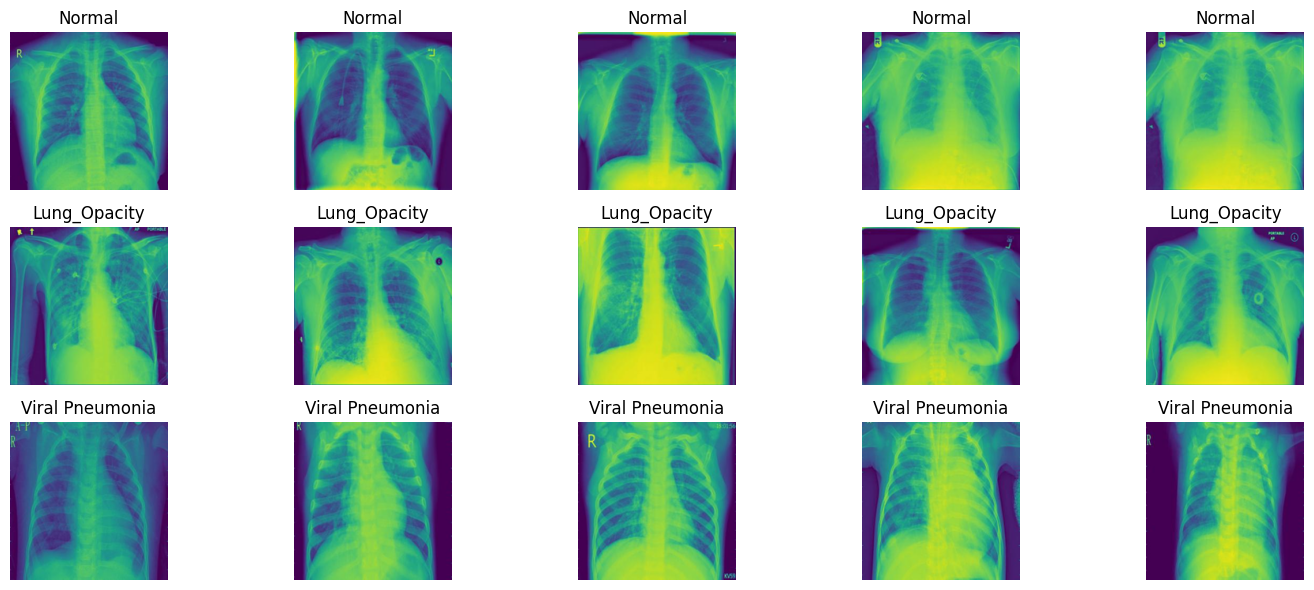

In [ ]:
fig, axes = plt.subplots(3, 5, figsize=(15, 6))
axes = axes.flatten()
index=0
# Iterate over categories
for category in (os.listdir(basepath)):
    if index >= 15:
          break  # Only display 10 images
    categoryfolder = os.path.join(basepath, category)
    images = os.listdir(categoryfolder)
    for j in range(5):
      # Select a random image from the category
      imgname = np.random.choice(images)
      imgpath = os.path.join(categoryfolder, imgname)
      image_pil = Image.open(imgpath)
      resized_image = image_pil.resize((IMG_SIZE,IMG_SIZE))
      #image_arr = cv2.cvtColor(image_arr, cv2.COLOR_BGR2RGB)  # Convert to RGB
      #print( newarr_img.shape)
      axes[index].imshow(resized_image)
      axes[index].set_title(category)
      axes[index].axis('off')
      index += 1

      if index >= 15:
          break  # Only display 10 images

plt.tight_layout()
plt.show()


In [ ]:
df=pd.DataFrame(columns=['img_url','label'])
def create_train_data():
    training_data=[]
      #iterate over categories folder
    for category in os.listdir(basepath):
        categoryfolder=os.path.join(basepath,category)

          #iterate over the images and add it to test list
        for img in os.listdir(categoryfolder):
                imgpath=os.path.join(categoryfolder,img)
                image_arr=cv2.imread(imgpath)
                newarr_img=cv2.resize(image_arr,(IMG_SIZE,IMG_SIZE))
                label=categories.index(category)
                training_data.append([newarr_img,label])
                df.loc[len(df)]=[imgpath,category]
                #plt.imshow(image_arr)



    return training_data

In [ ]:
train_data=create_train_data()

In [ ]:
df.head(1500)

img_url         label
0     /content/Lung X-Ray Image/Lung X-Ray Image/Nor...        Normal
1     /content/Lung X-Ray Image/Lung X-Ray Image/Nor...        Normal
2     /content/Lung X-Ray Image/Lung X-Ray Image/Nor...        Normal
3     /content/Lung X-Ray Image/Lung X-Ray Image/Nor...        Normal
4     /content/Lung X-Ray Image/Lung X-Ray Image/Nor...        Normal
...                                                 ...           ...
1495  /content/Lung X-Ray Image/Lung X-Ray Image/Lun...  Lung_Opacity
1496  /content/Lung X-Ray Image/Lung X-Ray Image/Lun...  Lung_Opacity
1497  /content/Lung X-Ray Image/Lung X-Ray Image/Lun...  Lung_Opacity
1498  /content/Lung X-Ray Image/Lung X-Ray Image/Lun...  Lung_Opacity
1499  /content/Lung X-Ray Image/Lung X-Ray Image/Lun...  Lung_Opacity

[1500 rows x 2 columns]

<Axes: xlabel='label'>

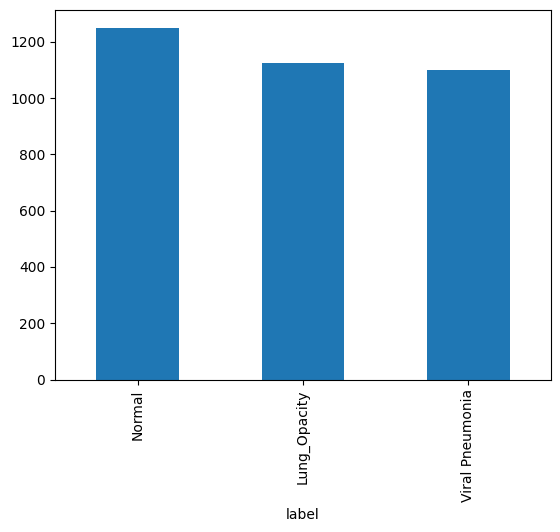

In [ ]:
labels_distribution=df['label'].value_counts()
labels_distribution.plot(kind='bar')

In [ ]:
train_df,test_df=train_test_split(df,test_size=0.2,random_state=42,stratify=df.label)
test_df,val_df=train_test_split(test_df,test_size=0.1,random_state=42,stratify=test_df.label)

In [ ]:
print(train_df.shape)
print(test_df.shape)
print(val_df.shape)

(2780, 2)
(625, 2)
(70, 2)


In [ ]:
train_datagen = ImageDataGenerator(rescale=1/255.,validation_split=0.2)

test_datagen = ImageDataGenerator(rescale=1/255.)

val_datagen  = ImageDataGenerator(rescale=1/255.)
train_generator = train_datagen.flow_from_dataframe(dataframe= train_df,x_col="img_url",y_col="label",
                                      target_size=(IMG_SIZE,IMG_SIZE),

                                      class_mode="categorical",
                                      batch_size=BATCH_SIZE,

                                     )

val_generator = val_datagen.flow_from_dataframe(dataframe= val_df,x_col="img_url",y_col="label",
                                      target_size=(IMG_SIZE,IMG_SIZE),

                                      class_mode="categorical",
                                      batch_size=BATCH_SIZE,
                                      shuffle=False
                                     )

test_generator = test_datagen.flow_from_dataframe(dataframe= test_df,x_col="img_url",y_col="label",
                                      target_size=(IMG_SIZE,IMG_SIZE),

                                      class_mode="categorical",
                                      batch_size=BATCH_SIZE,
                                      shuffle=False
                                     )

Found 2780 validated image filenames belonging to 3 classes.
Found 70 validated image filenames belonging to 3 classes.
Found 625 validated image filenames belonging to 3 classes.


In [ ]:
resize_scaling = tf.keras.Sequential([
    layers.Resizing(IMG_SIZE, IMG_SIZE),
    layers.Rescaling(1./255)
])

In [ ]:
model=keras.models.Sequential([
    keras.layers.Conv2D(32,kernel_size=(3,3),input_shape=(IMG_SIZE,IMG_SIZE,3),activation='relu'),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Conv2D(32,kernel_size=(3,3)),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Conv2D(32,kernel_size=(3,3),activation='relu'),
    keras.layers.MaxPooling2D((2,2)),

    keras.layers.Flatten(),

    keras.layers.Dense(128,activation='relu'),

    keras.layers.Dense(3,activation='softmax')


])
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 198, 198, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 99, 99, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 97, 97, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 48, 48, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 46, 46, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 23, 23, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 16928)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       2,166,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,186,691 (8.34 MB)

 Trainable params: 2,186,691 (8.34 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history=model.fit(train_generator,validation_data=val_generator,epochs=Epochs,batch_size=BATCH_SIZE)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


87/87 ━━━━━━━━━━━━━━━━━━━━ 15s 96ms/step - accuracy: 0.6085 - loss: 0.9063 - val_accuracy: 0.8571 - val_loss: 0.4399
Epoch 2/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.8248 - loss: 0.4186 - val_accuracy: 0.8571 - val_loss: 0.3794
Epoch 3/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - accuracy: 0.8645 - loss: 0.3386 - val_accuracy: 0.8571 - val_loss: 0.3763
Epoch 4/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.8773 - loss: 0.3212 - val_accuracy: 0.8571 - val_loss: 0.3862
Epoch 5/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.8872 - loss: 0.2749 - val_accuracy: 0.8571 - val_loss: 0.3726
Epoch 6/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - accuracy: 0.9061 - loss: 0.2235 - val_accuracy: 0.8571 - val_loss: 0.3582
Epoch 7/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.9183 - loss: 0.2025 - val_accuracy: 0.8714 - val_loss: 0.4794
Epoch 8/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.9188 - loss: 0.2056 - val_accuracy: 0.8714 - val_loss: 

In [ ]:
val,acc=model.evaluate(train_generator)

87/87 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 1.0000 - loss: 2.1824e-05


In [ ]:
val,acc=model.evaluate(test_generator)

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - accuracy: 0.8693 - loss: 1.1403


In [ ]:
true_value=test_generator.classes
pred=model.predict(test_generator)
pred=np.argmax(model.predict(test_generator),axis=1)
pred_class_name=[categories[p] for p in pred]
pred_class_name

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step


['Viral Pneumonia',
 'Viral Pneumonia',
 'Viral Pneumonia',
 'Viral Pneumonia',
 'Normal',
 'Viral Pneumonia',
 'Lung_Opacity',
 'Viral Pneumonia',
 'Viral Pneumonia',
 'Normal',
 'Viral Pneumonia',
 'Viral Pneumonia',
 'Viral Pneumonia',
 'Normal',
 'Viral Pneumonia',
 'Normal',
 'Lung_Opacity',
 'Lung_Opacity',
 'Normal',
 'Viral Pneumonia',
 'Normal',
 'Lung_Opacity',
 'Normal',
 'Normal',
 'Normal',
 'Lung_Opacity',
 'Lung_Opacity',
 'Lung_Opacity',
 'Normal',
 'Viral Pneumonia',
 'Normal',
 'Lung_Opacity',
 'Lung_Opacity',
 'Normal',
 'Normal',
 'Normal',
 'Lung_Opacity',
 'Normal',
 'Normal',
 'Lung_Opacity',
 'Viral Pneumonia',
 'Viral Pneumonia',
 'Lung_Opacity',
 'Lung_Opacity',
 'Lung_Opacity',
 'Lung_Opacity',
 'Lung_Opacity',
 'Normal',
 'Viral Pneumonia',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Lung_Opacity',
 'Lung_Opacity',
 'Viral Pneumonia',
 'Lung_Opacity',
 'Lung_Opacity',
 'Normal',
 'Lung_Opacity',
 'Normal',
 'Lung_Opacity',
 'Viral Pneumonia',
 'Normal',
 '

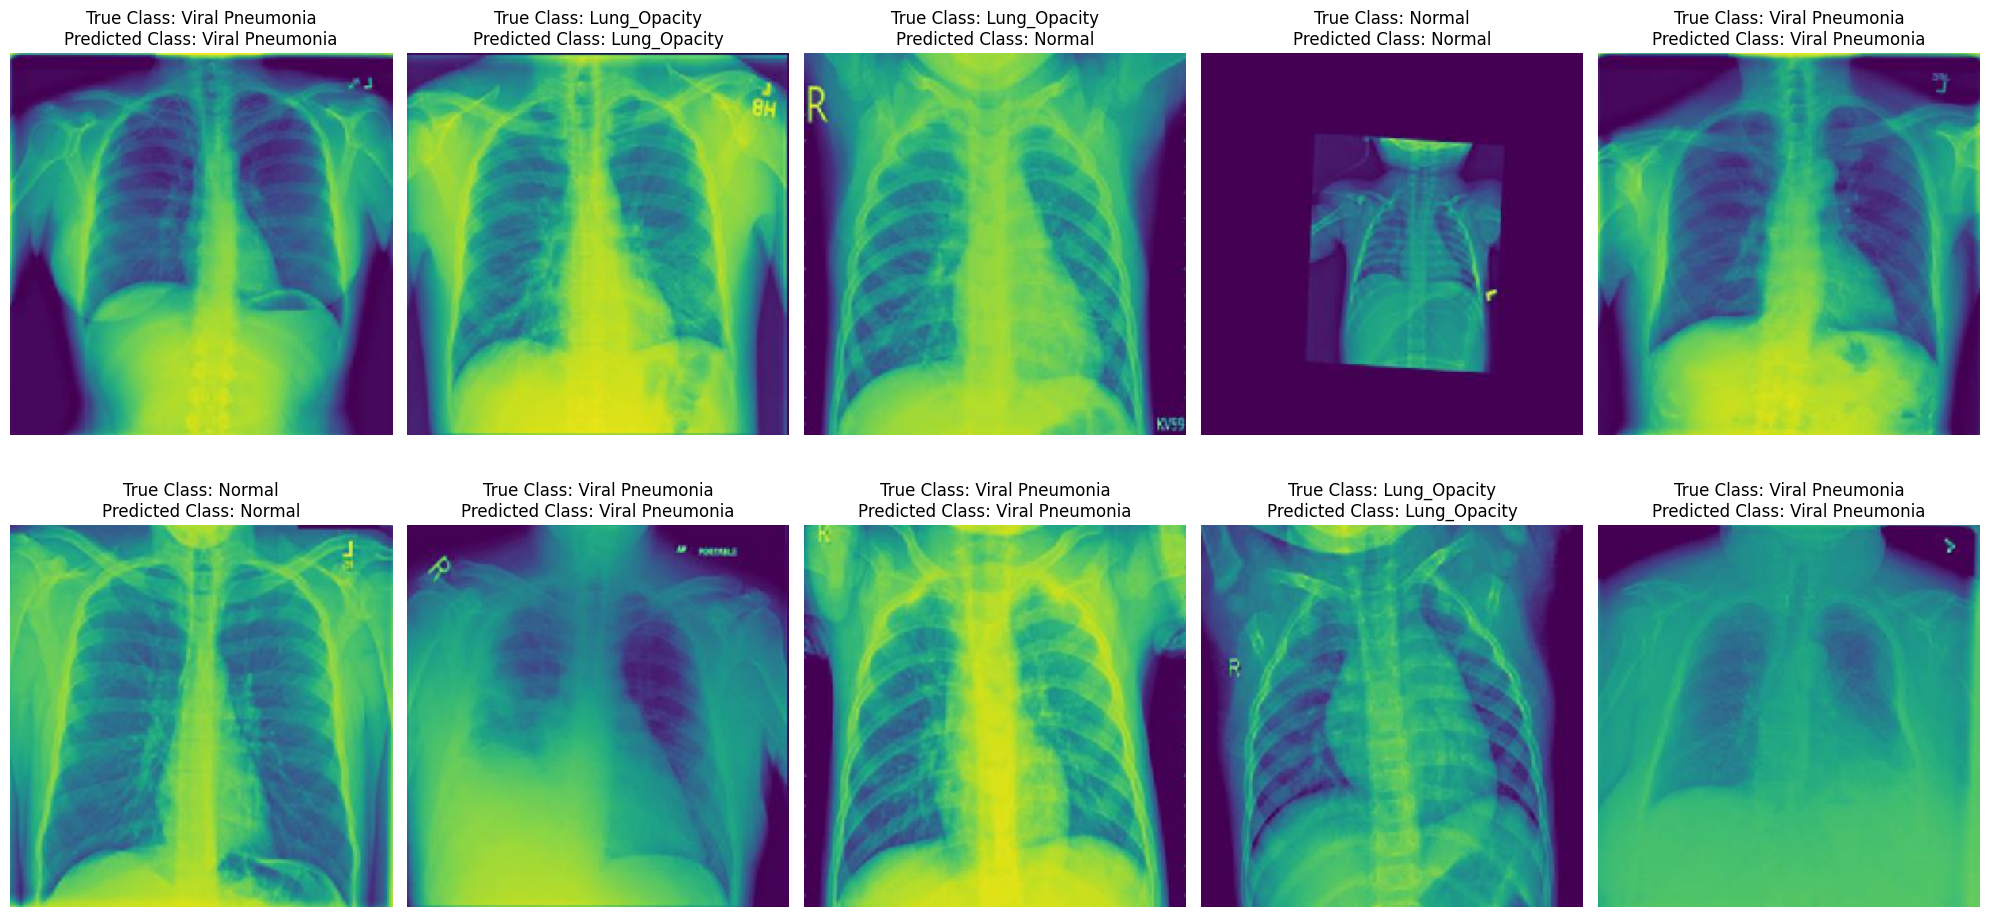

In [ ]:
plt.figure(figsize=(20, 10))

random_indices = np.random.choice(len(test_generator), size=10, replace=False)

# Plot true labels and predicted labels side by side
for idx, i in enumerate(random_indices):
    plt.subplot(2, 5, idx + 1)
    plt.imshow(test_generator[i][0][0])  # Display the first image of the batch
    plt.title(f"True Class: {categories[true_value[i]]}\nPredicted Class: {pred_class_name[i]}")
    plt.axis('off')


plt.tight_layout()
plt.show()

In [ ]:
print(confusion_matrix(true_value,pred))

[[167  35   0]
 [ 23 200   2]
 [  3   8 187]]


In [ ]:
!kaggle datasets download -d omkarmanohardalvi/lungs-disease-dataset-4-types

Dataset URL: https://www.kaggle.com/datasets/omkarmanohardalvi/lungs-disease-dataset-4-types
License(s): unknown
100% 2.02G/2.02G [00:32<00:00, 32.8MB/s]
100% 2.02G/2.02G [00:32<00:00, 67.5MB/s]


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/lungs-disease-dataset-4-types.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
import os
import cv2
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Conv2D,Flatten,Dense,MaxPool2D,Dropout
from sklearn.metrics import accuracy_score
import ipywidgets as widget
import os
from PIL import Image
import tqdm
from sklearn.model_selection import train_test_split
import cv2
from sklearn.utils import shuffle
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

X_train = []
Y_train = []
image_size = 150
labels = ['Bacterial Pneumonia','Corona Virus Disease', 'Normal', 'Tuberculosis', 'Viral Pneumonia']

# Load training data
for label in labels:
    folderPath = os.path.join('/content/Lung Disease Dataset/train', label)
    for filename in os.listdir(folderPath):
        img = cv2.imread(os.path.join(folderPath, filename))
        img = cv2.resize(img, (image_size, image_size))
        X_train.append(img)
        Y_train.append(label)

# Load testing data
for label in labels:
    folderPath = os.path.join('/content/Lung Disease Dataset/test', label)
    for filename in os.listdir(folderPath):
        img = cv2.imread(os.path.join(folderPath, filename))
        img = cv2.resize(img, (image_size, image_size))
        X_train.append(img)
        Y_train.append(label)

# Load validation data
for label in labels:
    folderPath = os.path.join('/content/Lung Disease Dataset/val', label)
    for filename in os.listdir(folderPath):
        img = cv2.imread(os.path.join(folderPath, filename))
        img = cv2.resize(img, (image_size, image_size))
        X_train.append(img)
        Y_train.append(label)

X_train = np.array(X_train)
Y_train = np.array(Y_train)

# Shuffle the data
X_train, Y_train = shuffle(X_train, Y_train, random_state=100)

# Split into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.2, random_state=100)

# Convert labels to categorical format
y_train = tf.keras.utils.to_categorical([labels.index(label) for label in y_train], num_classes=len(labels))
y_test = tf.keras.utils.to_categorical([labels.index(label) for label in y_test], num_classes=len(labels))

In [ ]:
y_train.shape

(8076, 5)

In [ ]:
x_train.shape

(8076, 150, 150, 3)

In [ ]:
x_test.shape

(2019, 150, 150, 3)

In [ ]:
y_test.shape

(2019, 5)

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# Load the pre-trained ResNet50 model (excluding the top classification layers)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Use GlobalAveragePooling instead of Flatten for better performance with ResNet
x = Dense(256, activation='relu')(x)
x = Dense(256, activation='relu')(x)
output = Dense(5, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 150, 150, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 156, 156, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 75, 75, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 75, 75, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 75, 75, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 77, 77, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 38, 38, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 38, 38, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 38, 38, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 38, 38, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 38, 38, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 38, 38, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 38, 38, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 38, 38, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 38, 38, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 24,179,333 (92.24 MB)

 Trainable params: 591,621 (2.26 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Recompile the model after adding new layers and before training
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    x_train, y_train, epochs=50, validation_split=0.1,
    callbacks=[early_stopping]
)

# Save the trained model
model.save('lung_disease_detection_model.h5')

# Evaluate the model on the test data
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Calculate accuracy, F1 score, precision, and recall
accuracy = accuracy_score(y_true, y_pred_classes)
f1 = f1_score(y_true, y_pred_classes, average='weighted')
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')

# Print the metrics
print(f'Accuracy: {accuracy}')
print(f'F1 Score: {f1}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')

Epoch 1/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 31s 88ms/step - accuracy: 0.7215 - loss: 0.7377 - val_accuracy: 0.8478 - val_loss: 0.3696
Epoch 2/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 28s 48ms/step - accuracy: 0.8340 - loss: 0.3804 - val_accuracy: 0.8688 - val_loss: 0.3330
Epoch 3/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 20s 48ms/step - accuracy: 0.8636 - loss: 0.3183 - val_accuracy: 0.8651 - val_loss: 0.3258
Epoch 4/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 21s 48ms/step - accuracy: 0.8793 - loss: 0.2776 - val_accuracy: 0.8750 - val_loss: 0.3157
Epoch 5/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 20s 48ms/step - accuracy: 0.8840 - loss: 0.2649 - val_accuracy: 0.8515 - val_loss: 0.3572
Epoch 6/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 21s 48ms/step - accuracy: 0.9080 - loss: 0.2247 - val_accuracy: 0.8527 - val_loss: 0.3640
Epoch 7/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 11s 49ms/step - accuracy: 0.9065 - loss: 0.2256 - val_accuracy: 0.8725 - val_loss: 0.3152
Epoch 8/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 21s 50ms/step - accuracy: 0.9175 - loss: 0.1990 - 

64/64 ━━━━━━━━━━━━━━━━━━━━ 10s 99ms/step
Accuracy: 0.8662704309063893
F1 Score: 0.8670425535924645
Precision: 0.8699645798805415
Recall: 0.8662704309063893


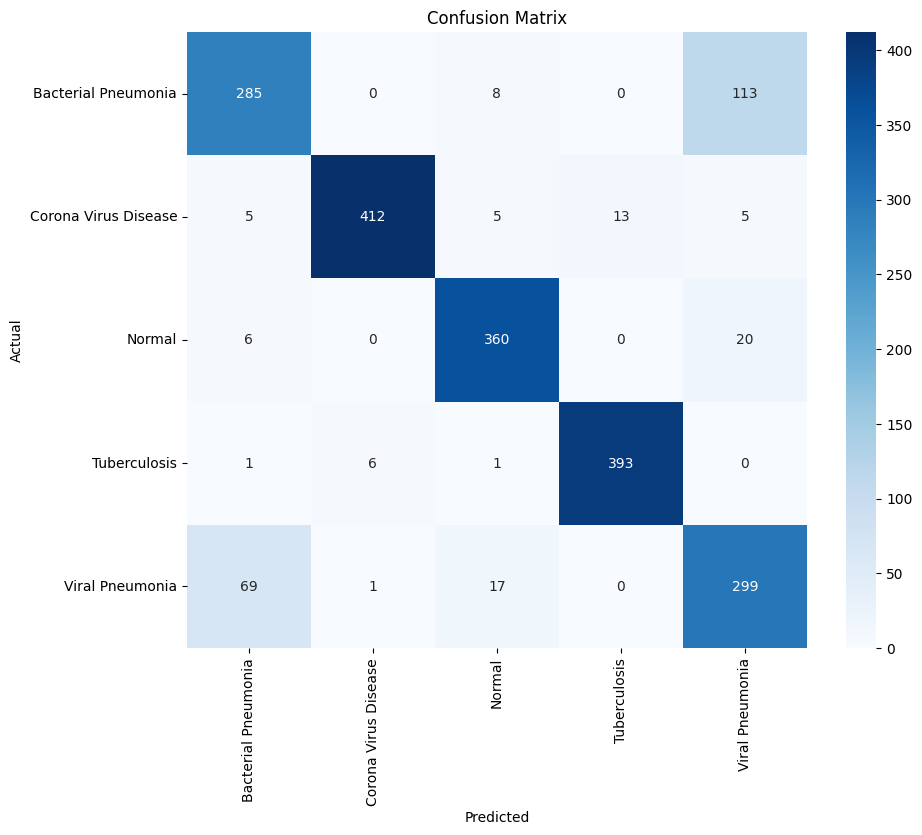

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
class_names = ['Bacterial Pneumonia','Corona Virus Disease', 'Normal', 'Tuberculosis', 'Viral Pneumonia']
# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import os
from sklearn.metrics import classification_report

# Load the trained model
model = load_model('/content/lung_disease_detection_model.h5')

# Path to the single unseen image
unseen_image_path = '/content/Lung Disease Dataset/test/Tuberculosis/Tuberculosis-101.jpg'

# Define image dimensions and other preprocessing parameters
img_height = 150  # Replace with your model's input height
img_width = 150   # Replace with your model's input width

# Load and preprocess the unseen image
img = load_img(unseen_image_path, target_size=(img_height, img_width))
img_array = img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

# Make predictions on the unseen image
y_pred_unseen = model.predict(img_array)
y_pred_class = np.argmax(y_pred_unseen, axis=1)[0]

# Define class names (replace these with your actual class names)
class_names = ['Bacterial Pneumonia', 'Corona Virus Disease', 'Normal', 'Tuberculosis', 'Viral Pneumonia']

# Print the predicted class for the image
print(f'Filename: {unseen_image_path} - Predicted Class: {class_names[y_pred_class]}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Filename: /content/Lung Disease Dataset/test/Tuberculosis/Tuberculosis-101.jpg - Predicted Class: Tuberculosis


breast cancer

breast cancer

In [ ]:
!kaggle datasets download -d awsaf49/cbis-ddsm-breast-cancer-image-dataset

Dataset URL: https://www.kaggle.com/datasets/awsaf49/cbis-ddsm-breast-cancer-image-dataset
License(s): CC-BY-SA-3.0
100% 4.95G/4.95G [01:10<00:00, 30.6MB/s]
100% 4.95G/4.95G [01:10<00:00, 75.4MB/s]


In [ ]:
!kaggle datasets download -d aryashah2k/breast-ultrasound-images-dataset

Dataset URL: https://www.kaggle.com/datasets/aryashah2k/breast-ultrasound-images-dataset
License(s): CC0-1.0
 92% 179M/195M [00:02<00:00, 88.3MB/s]
100% 195M/195M [00:02<00:00, 75.8MB/s]


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/breast-ultrasound-images-dataset.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import copy
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from PIL import Image  # Import PIL to resize images
import shutil

import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import random
from sklearn.model_selection import train_test_split

import torch.optim as optim
from torch.optim import lr_scheduler
from sklearn.metrics import classification_report, confusion_matrix

import seaborn as sns
from torchvision.transforms import RandomHorizontalFlip, RandomRotation, ColorJitter

<ipython-input-7-7ca049bed202>:28: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  image = image.resize((desired_width, desired_height), Image.ANTIALIAS)


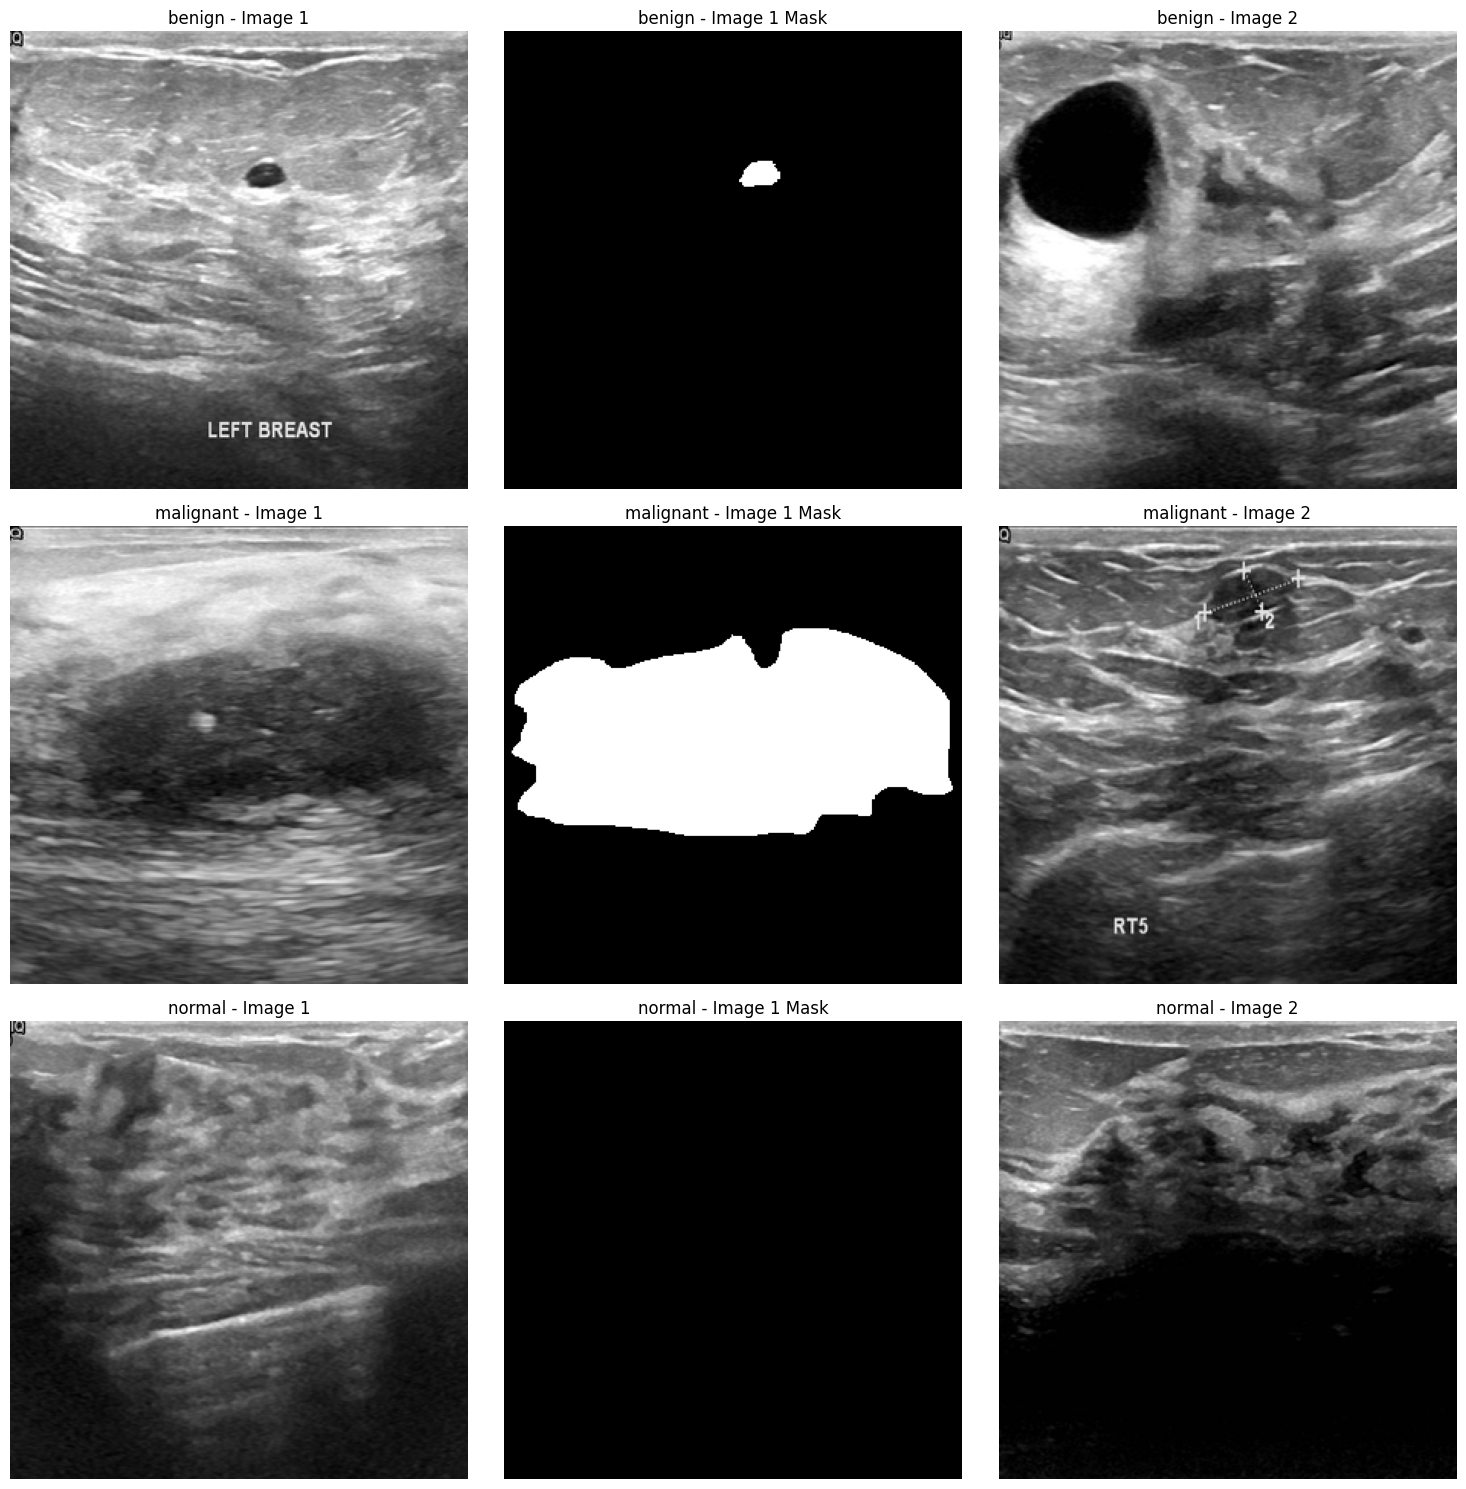

In [ ]:
# Define the labels and corresponding directories
labels = ['benign', 'malignant', 'normal']
# Update the data directory to the correct path
data_dir = "/content/Dataset_BUSI_with_GT"  # Update with your actual dataset path

# Create a figure to display the images
fig, axs = plt.subplots(3, 3, figsize=(15, 15))

# Desired width and height for each image
desired_width = 300  # Adjust as needed
desired_height = 300  # Adjust as needed

for i, label in enumerate(labels):
    label_dir = os.path.join(data_dir, label)

    # Get a list of image files
    image_files = [file for file in os.listdir(label_dir) if file.endswith('.png')]

    # Sort the list of image files
    image_files = sorted(image_files)

    # Loop through the first 4 image files
    for j in range(3):
        if j < len(image_files):
            # Load and resize the image
            image_path = os.path.join(label_dir, image_files[j])
            image = Image.open(image_path)
            image = image.resize((desired_width, desired_height), Image.ANTIALIAS)

            # Determine the label based on whether it's an image or a mask
            if j % 2 == 0:
                image_label = f'{label} - Image {j // 2 + 1}'
            else:
                image_label = f'{label} - Image {j // 2 + 1} Mask'

            # Display the image with the corresponding label
            axs[i, j].imshow(image)
            axs[i, j].set_title(image_label)
            axs[i, j].axis('off')

plt.tight_layout()
plt.show()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


40/40 ━━━━━━━━━━━━━━━━━━━━ 17s 227ms/step - accuracy: 0.4847 - loss: 12.7498 - val_accuracy: 0.6772 - val_loss: 0.7904
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.6332 - loss: 0.8789 - val_accuracy: 0.7089 - val_loss: 0.7102
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.6633 - loss: 0.8219 - val_accuracy: 0.7278 - val_loss: 0.6930
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - accuracy: 0.6487 - loss: 0.7924 - val_accuracy: 0.6108 - val_loss: 0.7571
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.6128 - loss: 0.8191 - val_accuracy: 0.6329 - val_loss: 0.7401
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.6673 - loss: 0.8150 - val_accuracy: 0.7120 - val_loss: 0.6748
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.6639 - loss: 0.7730 - val_accuracy: 0.5285 - val_loss: 0.8461
Epoch 8/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.5705 - loss: 0.8587 - val_accuracy: 0.5601 - val_loss:

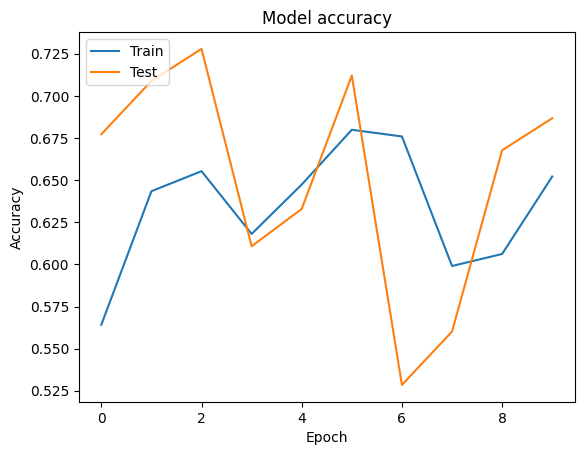

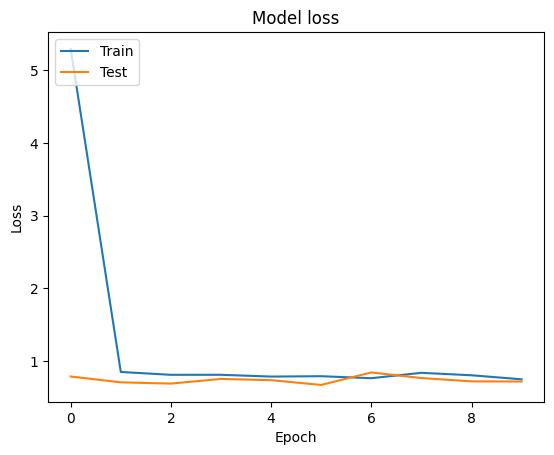

In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Load the dataset
def load_data(data_dir):
    images = []
    labels = []
    label_map = {'benign': 0, 'malignant': 1, 'normal': 2}

    for label in label_map.keys():
        path = os.path.join(data_dir, label)
        class_num = label_map[label]
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                img_array = cv2.resize(img_array, (128, 128))
                images.append(img_array)
                labels.append(class_num)
            except Exception as e:
                print(f"Error loading image {img}: {e}")

    images = np.array(images).reshape(-1, 128, 128, 1)
    labels = np.array(labels)
    return images, labels

# Data Augmentation
def augment_data(images, labels):
    datagen = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    datagen.fit(images)
    return datagen.flow(images, labels, batch_size=32)

# Build the CNN model
def build_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),

        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(3, activation='softmax')  # Updated to handle 3 classes
    ])

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Load data
data_dir = '/content/Dataset_BUSI_with_GT'
images, labels = load_data(data_dir)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Data augmentation
train_generator = augment_data(X_train, y_train)

# Build and train the model
model = build_model()
history = model.fit(train_generator, epochs=10, validation_data=(X_test, y_test))

# Evaluate the model
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred_classes, target_names=['benign', 'malignant', 'normal']))
print(confusion_matrix(y_test, y_pred_classes))

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Load the dataset
def load_data(data_dir):
    images = []
    labels = []
    label_map = {'benign': 0, 'malignant': 1, 'normal': 2}

    for label in label_map.keys():
        path = os.path.join(data_dir, label)
        class_num = label_map[label]
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                img_array = cv2.resize(img_array, (128, 128))
                images.append(img_array)
                labels.append(class_num)
            except Exception as e:
                print(f"Error loading image {img}: {e}")

    images = np.array(images).reshape(-1, 128, 128, 1)
    labels = np.array(labels)
    return images, labels

# Data Augmentation
def augment_data(images, labels):
    datagen = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    datagen.fit(images)
    return datagen.flow(images, labels, batch_size=32)

# Build the CNN model
def build_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),

        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(3, activation='softmax')  # Updated to handle 3 classes
    ])

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Load data
data_dir = '/content/Dataset_BUSI_with_GT'
images, labels = load_data(data_dir)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Data augmentation
train_generator = augment_data(X_train, y_train)

# Build and train the model
model = build_model()
history = model.fit(train_generator, epochs=50, validation_data=(X_test, y_test))

# Function to classify a single image
def classify_image(model, image_path):
    img_array = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img_array = cv2.resize(img_array, (128, 128))
    img_array = img_array.reshape(1, 128, 128, 1)
    img_array = img_array / 255.0  # Normalize

    prediction = model.predict(img_array)
    class_idx = np.argmax(prediction)
    class_labels = ['benign', 'malignant', 'normal']
    predicted_class = class_labels[class_idx]

    print(f"The image belongs to class: {predicted_class}")
    return predicted_class

# Example usage:
# Replace 'path_to_your_image' with the actual path of the image you want to classify
image_path = '/content/Dataset_BUSI_with_GT/normal/normal (10).png'
classify_image(model, image_path)


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 158ms/step - accuracy: 0.5171 - loss: 8.7675 - val_accuracy: 0.6266 - val_loss: 0.8992
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.5314 - loss: 0.9502 - val_accuracy: 0.6709 - val_loss: 0.7736
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.5548 - loss: 0.8576 - val_accuracy: 0.6582 - val_loss: 0.7598
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.5715 - loss: 0.8190 - val_accuracy: 0.6646 - val_loss: 0.7345
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - accuracy: 0.5830 - loss: 0.7975 - val_accuracy: 0.6456 - val_loss: 0.8000
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.5635 - loss: 0.8650 - val_accuracy: 0.6741 - val_loss: 0.7587
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.5719 - loss: 0.8545 - val_accuracy: 0.6899 - val_loss: 0.7312
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.5888 - loss: 0.8127 - val_accuracy: 0.6519 - val_loss: 

'normal'

In [ ]:
image_path = '/content/Dataset_BUSI_with_GT/malignant/malignant (10).png'
classify_image(model, image_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
The image belongs to class: normal


'normal'

In [ ]:
2222222222222222222222222222222222222222222222222222222222

mri

In [ ]:
!kaggle datasets download -d uzairkhan45/breast-cancer-patients-mris

Dataset URL: https://www.kaggle.com/datasets/uzairkhan45/breast-cancer-patients-mris
License(s): CC0-1.0
 86% 49.0M/56.9M [00:00<00:00, 85.6MB/s]
100% 56.9M/56.9M [00:00<00:00, 86.4MB/s]
